<h1>AI-Modell för KokoBananas</h1>

---

<h3>Import</h3>

In [370]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split

import warnings 
warnings.filterwarnings('ignore')

---

<h3>EDA</h3>

In [354]:
df = pd.read_csv("../data/project_data.csv")
print(df.info())
print(df.isnull().sum())
print(df.describe())
print(df.columns)
df = df.drop(columns="Unnamed: 0", axis=1) # Verkar vara en gammal index kolumn

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               12330 non-null  int64  
 1   Administrative           12330 non-null  int64  
 2   Administrative_Duration  12330 non-null  float64
 3   Informational            12330 non-null  int64  
 4   Informational_Duration   12330 non-null  float64
 5   ProductRelated           12330 non-null  int64  
 6   ProductRelated_Duration  12330 non-null  float64
 7   BounceRates              12330 non-null  float64
 8   ExitRates                12330 non-null  float64
 9   PageValues               12330 non-null  float64
 10  SpecialDay               12207 non-null  float64
 11  Month                    12330 non-null  object 
 12  OperatingSystems         12330 non-null  int64  
 13  Browser                  12146 non-null  float64
 14  Region                

In [355]:
print(f"shape: {df.shape}")
rows_with_nulls = df.isnull().any(axis=1).sum()
print("Row count with null:", rows_with_nulls)
df.head(10)

shape: (12330, 18)
Row count with null: 687


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.0,Feb,1,NaN,1.0,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.0,0.0,Feb,2,2.0,NaN,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.0,Feb,4,1.0,NaN,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.0,0.0,Feb,3,2.0,2.0,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.0,0.0,Feb,3,3.0,1.0,4,Returning_Visitor,True,False
5,0,0.0,0,0.0,19,154.216667,0.015789,0.024561,0.0,0.0,Feb,2,2.0,1.0,3,Returning_Visitor,False,False
6,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.4,Feb,2,4.0,3.0,3,Returning_Visitor,False,False
7,1,0.0,0,0.0,0,0.000000,0.200000,0.200000,0.0,0.0,Feb,1,2.0,1.0,5,Returning_Visitor,True,False
8,0,0.0,0,0.0,2,37.000000,0.000000,0.100000,0.0,0.8,Feb,2,2.0,2.0,3,Returning_Visitor,False,False
9,0,0.0,0,0.0,3,738.000000,0.000000,0.022222,0.0,0.4,Feb,2,4.0,1.0,2,Returning_Visitor,False,False


In [356]:
unique_values = [df[col].unique() for col in df.columns]
for col, unique_val in zip(df.columns, unique_values):
    print(f"Unique values in column {col}: {unique_val}")


Unique values in column Administrative: [  0   1   2   4  12   3  10   6  -3  -8  -1   5   9  -7 -10   8  16  13
  11   7  -9  18  14  -5  17  19  15  -2  24  -6  -4  22  21  20  23  27
  26]
Unique values in column Administrative_Duration: [  0.         53.         64.6       ... 167.9107143 305.125
 150.3571429]
Unique values in column Informational: [ 0  1  2  4 16  5  3 14  6 12  7  9 10  8 11 24 13]
Unique values in column Informational_Duration: [  0.   120.    16.   ... 547.75 368.25 211.25]
Unique values in column ProductRelated: [  1   2  10  19   0   3  16   7   6  23  13  20   8   5  32   4  45  14
  52   9  46  15  22  11  12  36  42  27  90  18  38  17 128  25  30  21
  51  26  28  31  24  50  96  49  68  98  67  55  35  37  29  34  71  63
  87  40  33  54  64  75  39 111  81  61  47  44  88 149  41  79  66  43
 258  80  62  83 173  48  58  57  56  69  82  59 109 287  53  84  78 137
 113  89  65  60 104 129  77  74  93  76  72 194 140 110 132 115  73 328
 160  86 150  95 1

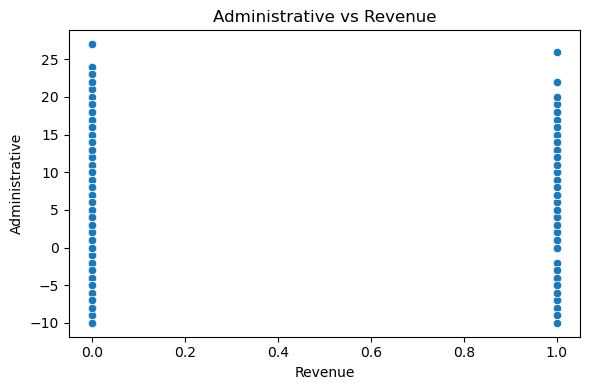

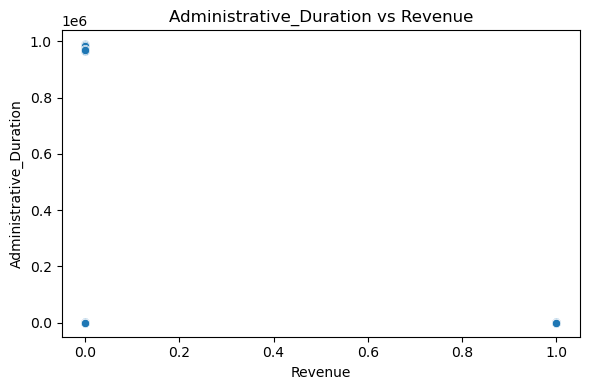

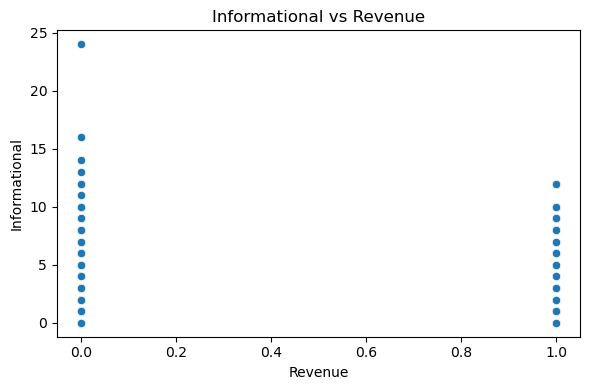

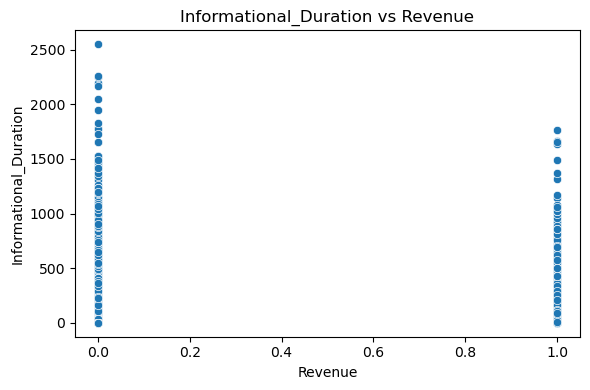

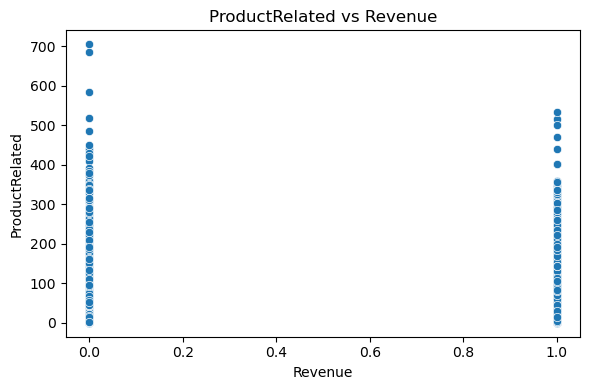

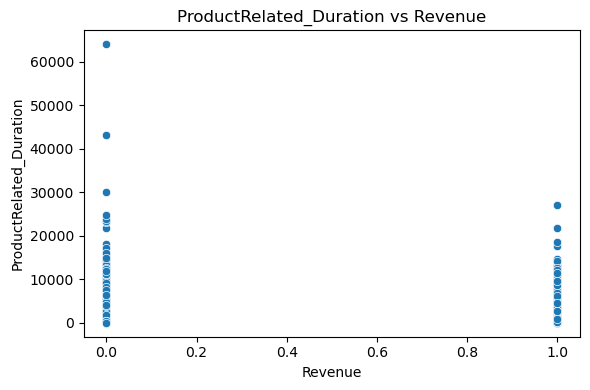

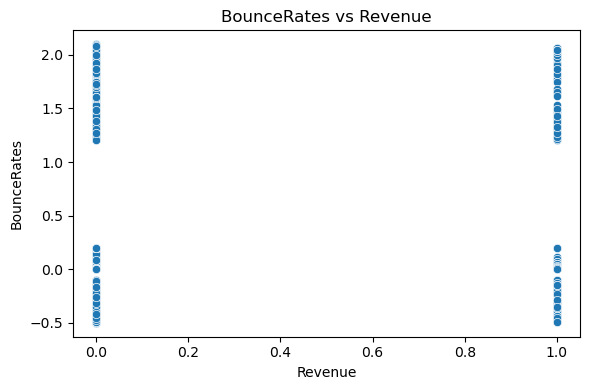

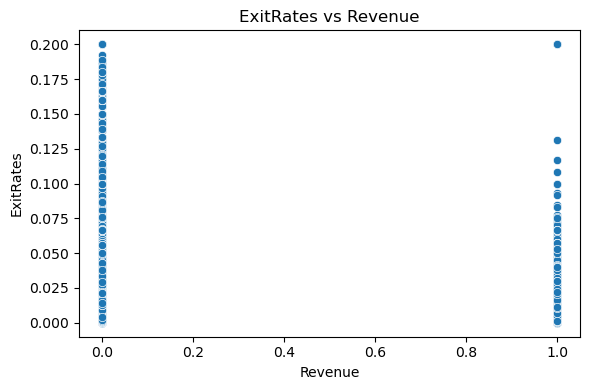

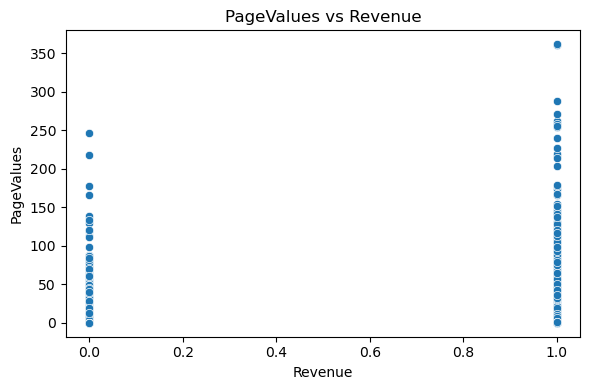

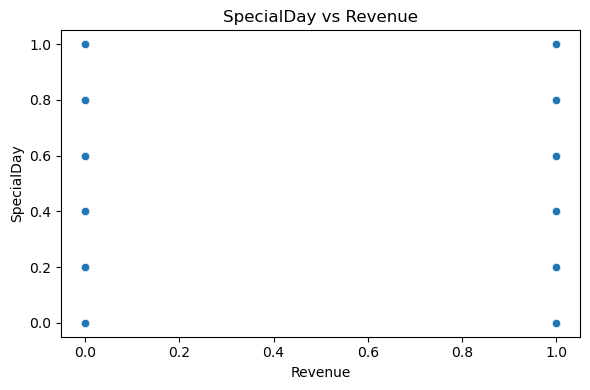

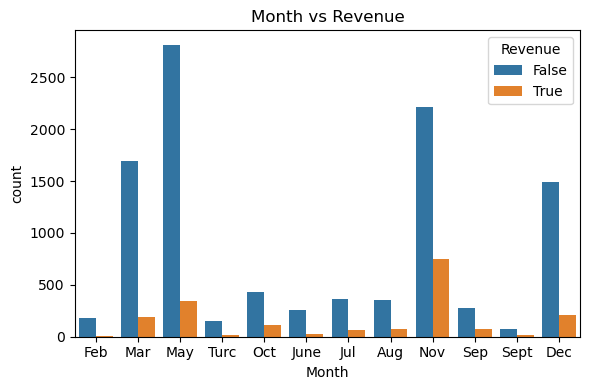

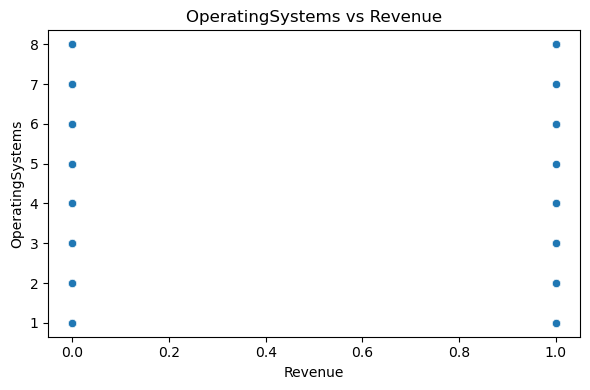

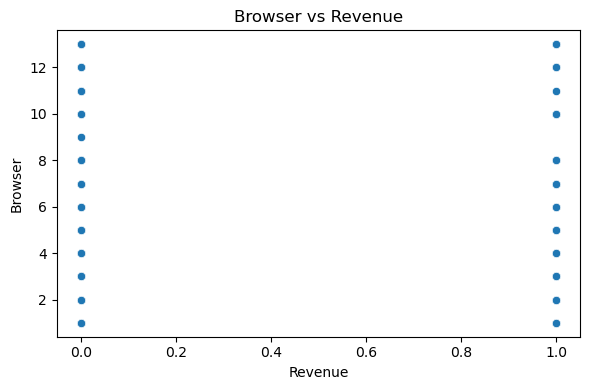

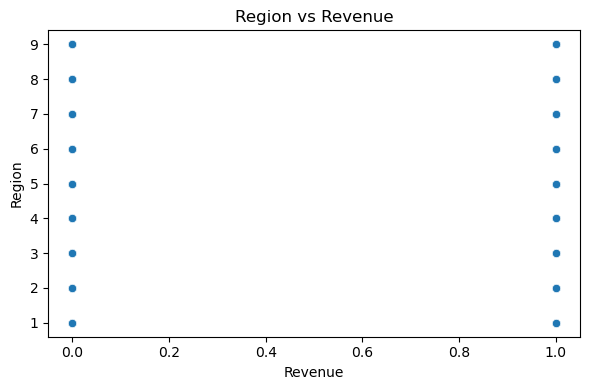

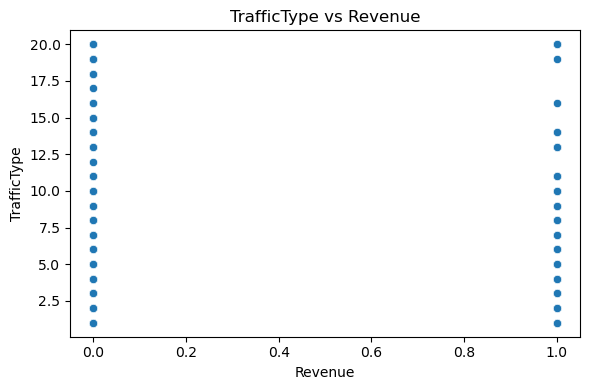

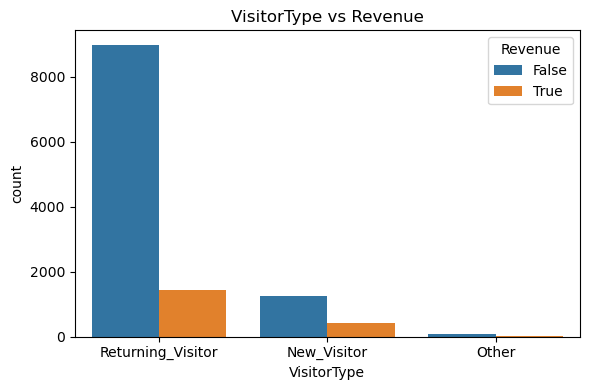

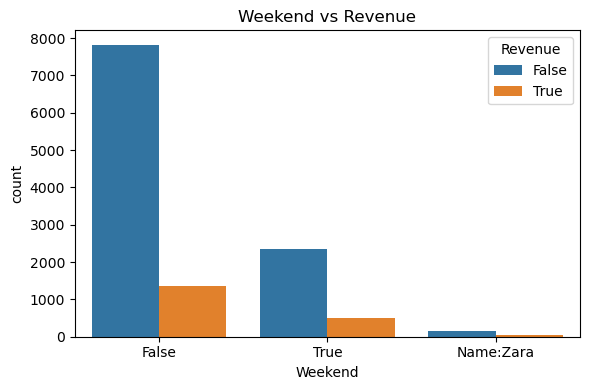

In [357]:
target_col = "Revenue"

for col in df.columns:
    if col != target_col:
        plt.figure(figsize=(6, 4))

        if pd.api.types.is_numeric_dtype(df[col]):
            sns.scatterplot(x=target_col, y=col, data=df)
        else:
            sns.countplot(x=col, hue=target_col, data=df)
        
        plt.title(f"{col} vs {target_col}")
        plt.tight_layout()
        plt.show()


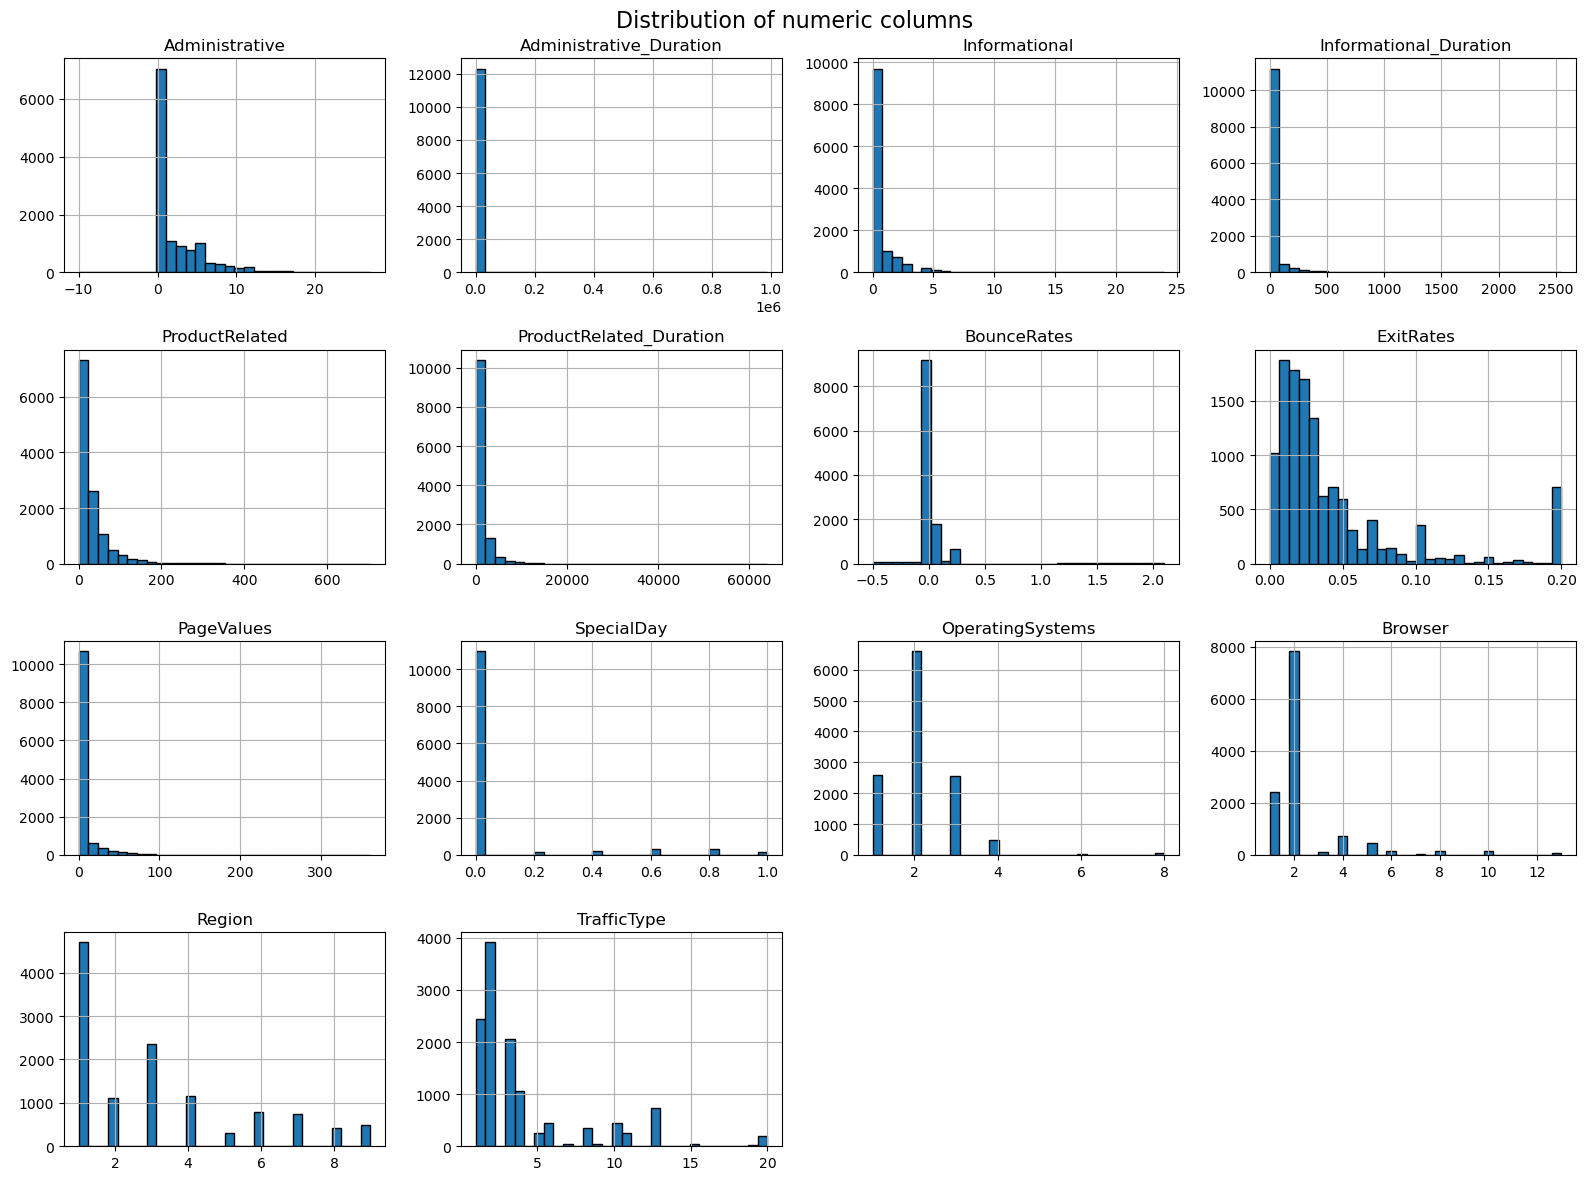

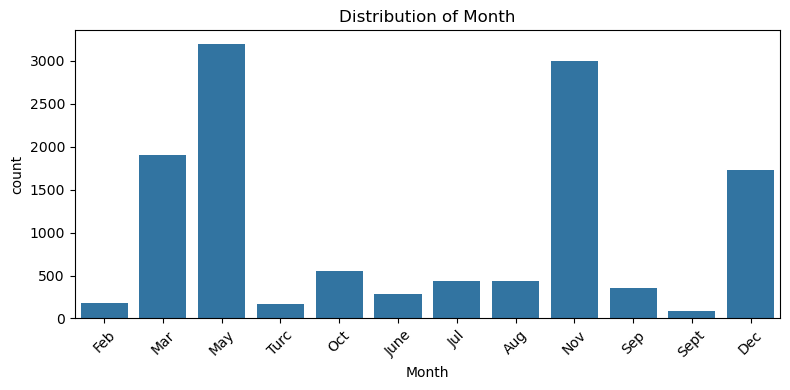

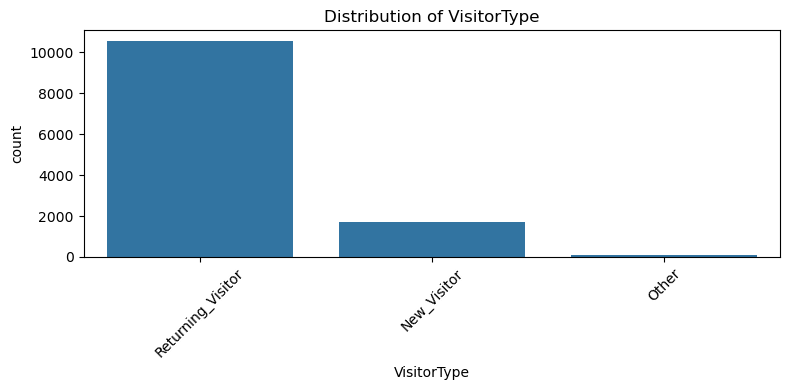

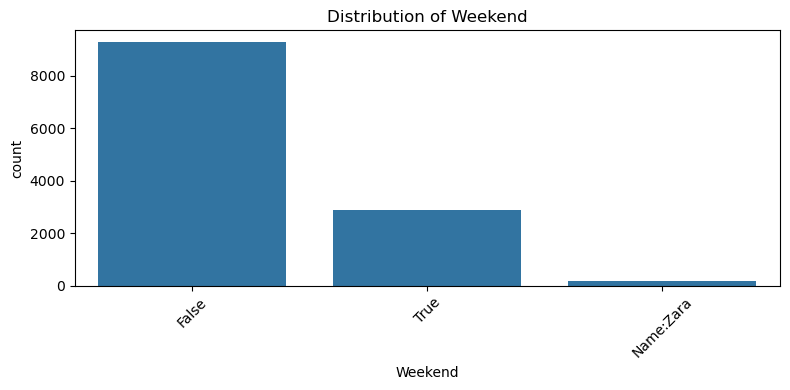

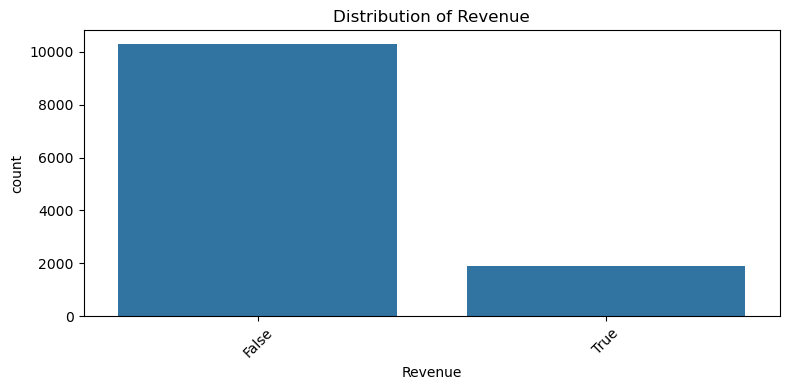

In [358]:
numerical_cols = df.select_dtypes(include=["float64", "int64"]).columns
df[numerical_cols].hist(figsize=(16, 12), bins=30, edgecolor='black')
plt.suptitle("Distribution of numeric columns", fontsize=16)
plt.tight_layout()
plt.show()

categorical_cols = df.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, data=df)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [359]:
print(df["SpecialDay"].value_counts())
print(df["SpecialDay"].isnull().sum())

print(df["Browser"].value_counts())
print(df["Browser"].isnull().sum())

print(df["Region"].value_counts())
print(df["Region"].isnull().sum())

SpecialDay
0.0    10971
0.6      346
0.8      321
0.4      240
0.2      177
1.0      152
Name: count, dtype: int64
123
Browser
2.0     7835
1.0     2424
4.0      725
5.0      465
6.0      171
10.0     160
8.0      135
3.0      104
13.0      61
7.0       49
12.0      10
11.0       6
9.0        1
Name: count, dtype: int64
184
Region
1.0    4695
3.0    2345
4.0    1157
2.0    1113
6.0     787
7.0     743
9.0     501
8.0     427
5.0     316
Name: count, dtype: int64
246


---

<h3>Data Preprocessing</h3>

In [360]:
print(f"Before change: {df['Weekend'].value_counts()}") # När jag kollar kaggle dokumentation verkar den vara 2868(True) och 9462(False) så jag grundar att lägga över alla Name:Zara som False då det är de värden som ligger fel
df.loc[df["Weekend"] == "Name:Zara", "Weekend"] = "False"
print(f"After change: {df['Weekend'].value_counts()}")


Before change: Weekend
False        9273
True         2868
Name:Zara     189
Name: count, dtype: int64
After change: Weekend
False    9462
True     2868
Name: count, dtype: int64


In [361]:
df = df.dropna(subset=["Revenue"])    #Ta bort rader med NAN i min target kolumn, eftersom antalet är litet och jag inte vill introducera bias i data
df = pd.get_dummies(df, columns=["Revenue"], dtype=int, drop_first=True)
df = pd.get_dummies(df, columns=["Weekend"], dtype=int, drop_first=True)
df = pd.get_dummies(df, columns=["VisitorType"], dtype=int, drop_first=True)
df.rename(columns={"VisitorType_Returning_Visitor": "Returning_Visitor"}, inplace=True)

print(df.info())
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 12183 entries, 0 to 12329
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12183 non-null  int64  
 1   Administrative_Duration  12183 non-null  float64
 2   Informational            12183 non-null  int64  
 3   Informational_Duration   12183 non-null  float64
 4   ProductRelated           12183 non-null  int64  
 5   ProductRelated_Duration  12183 non-null  float64
 6   BounceRates              12183 non-null  float64
 7   ExitRates                12183 non-null  float64
 8   PageValues               12183 non-null  float64
 9   SpecialDay               12061 non-null  float64
 10  Month                    12183 non-null  object 
 11  OperatingSystems         12183 non-null  int64  
 12  Browser                  12001 non-null  float64
 13  Region                   11939 non-null  float64
 14  TrafficType              12

Administrative               0
Administrative_Duration      0
Informational                0
Informational_Duration       0
ProductRelated               0
ProductRelated_Duration      0
BounceRates                  0
ExitRates                    0
PageValues                   0
SpecialDay                 122
Month                        0
OperatingSystems             0
Browser                    182
Region                     244
TrafficType                  0
Revenue_True                 0
Weekend_True                 0
VisitorType_Other            0
Returning_Visitor            0
dtype: int64

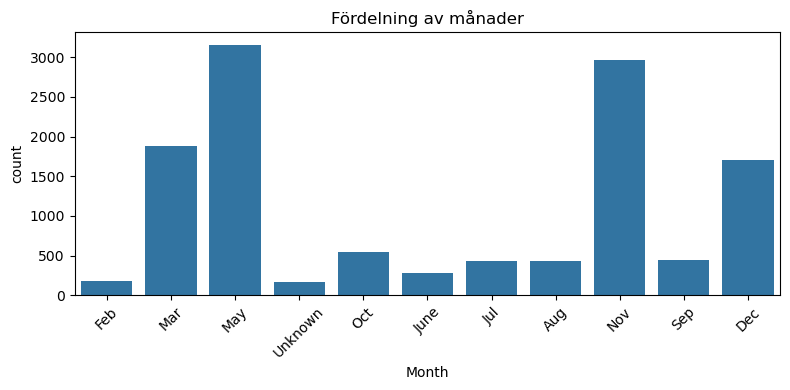

<class 'pandas.core.frame.DataFrame'>
Index: 12183 entries, 0 to 12329
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12183 non-null  int64  
 1   Administrative_Duration  12183 non-null  float64
 2   Informational            12183 non-null  int64  
 3   Informational_Duration   12183 non-null  float64
 4   ProductRelated           12183 non-null  int64  
 5   ProductRelated_Duration  12183 non-null  float64
 6   BounceRates              12183 non-null  float64
 7   ExitRates                12183 non-null  float64
 8   PageValues               12183 non-null  float64
 9   SpecialDay               12061 non-null  float64
 10  OperatingSystems         12183 non-null  int64  
 11  Browser                  12001 non-null  float64
 12  Region                   11939 non-null  float64
 13  TrafficType              12183 non-null  int64  
 14  Revenue_True             12

In [362]:
df["Month"] = df["Month"].replace("Sept", "Sep") #Det troliga att någon har skrivit sept istället för sep så jag har slagit ihop de till samma månad
df["Month"] = df["Month"].replace("Turc", "Unknown") #Jag kan inte gissa vilken månad "Turc" är så den får vara "Unknown"

plt.figure(figsize=(8, 4))
sns.countplot(x=df["Month"], data=df)
plt.title("Fördelning av månader")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
df = pd.get_dummies(df, columns=["Month"], dtype=int, drop_first=True)
df.info()

In [363]:
df["Administrative"] = df["Administrative"].abs() #Jag märkte att det fanns negativa värden som jag ändrar till poitiva då de inte bör vara negativa
print(df["Administrative"].unique())

[ 0  1  2  4 12  3 10  6  8  5  7 16 13 11  9 18 14 17 19 15 24 22 21 20
 23 27 26]


In [364]:
df["SpecialDay"] = df["SpecialDay"].fillna(-1.0).astype(float)
df["Browser"] = df["Browser"].fillna(-1.0).astype(float)
df["Region"] = df["Region"].fillna(-1.0).astype(float)
df.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
Revenue_True               0
Weekend_True               0
VisitorType_Other          0
Returning_Visitor          0
Month_Dec                  0
Month_Feb                  0
Month_Jul                  0
Month_June                 0
Month_Mar                  0
Month_May                  0
Month_Nov                  0
Month_Oct                  0
Month_Sep                  0
Month_Unknown              0
dtype: int64

In [365]:
df = df[[col for col in df.columns if col != "Revenue_True"] + ["Revenue_True"]] # Lägger min target som sista kolumn


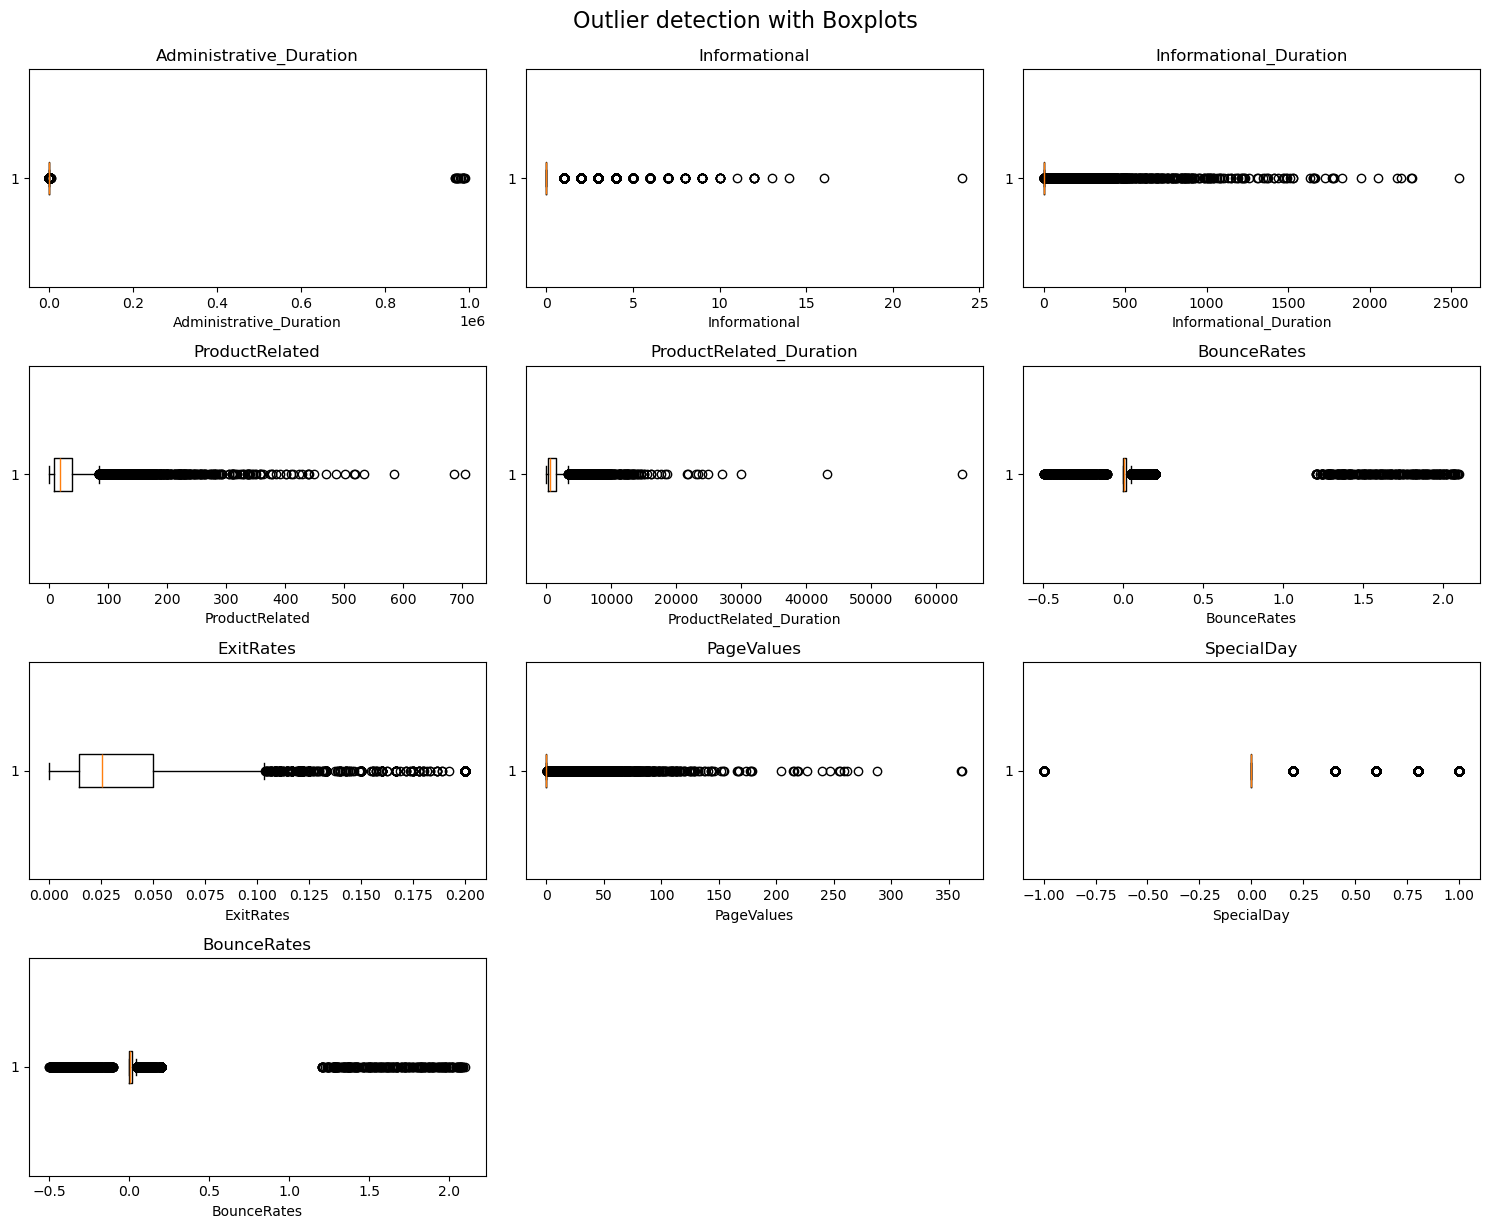

In [366]:
#Försöka visulaiser outliers
columns = [
    "Administrative_Duration", "Informational", "Informational_Duration", "ProductRelated", "ProductRelated_Duration",
    "BounceRates", "ExitRates", "PageValues", "SpecialDay", "BounceRates"
]
n_cols = 3
n_rows = (len(columns) + n_cols - 1) // n_cols 

plt.figure(figsize=(n_cols * 5, n_rows * 3))

for i, col in enumerate(columns):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.boxplot(df[col], vert=False)
    plt.title(col)
    plt.xlabel(col)

plt.tight_layout()
plt.suptitle("Outlier detection with Boxplots", fontsize=16, y=1.02)
plt.show()

Jag måste hantera outliers på något sätt, läste om "Pipeline" och "RobustScaler" som jag tänkte testa efter traint/test split.

In [367]:
df[df["BounceRates"] < 0]

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend_True,VisitorType_Other,Returning_Visitor,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,Month_Unknown,Revenue_True
15,2,53.00,0,0.0,23,1668.285119,-0.395564,0.016313,0.000000,0.0,1,1.0,9.0,3,0,0,1,0,1,0,0,0,0,0,0,0,0,0
24,0,0.00,0,0.0,1,0.000000,-0.383570,0.200000,0.000000,0.0,2,2.0,-1.0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0
42,0,0.00,0,0.0,15,310.166667,-0.409885,0.006667,0.000000,0.0,1,1.0,4.0,4,0,0,1,0,1,0,0,0,0,0,0,0,0,0
45,0,0.00,0,0.0,22,622.250000,-0.458046,0.006061,0.000000,0.2,2,5.0,1.0,4,0,0,1,0,1,0,0,0,0,0,0,0,0,0
67,0,0.00,0,0.0,1,0.000000,-0.141745,0.200000,0.000000,0.6,2,2.0,5.0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12032,1,58.50,0,0.0,23,1033.000000,-0.166448,0.037500,0.000000,0.0,2,2.0,3.0,2,0,0,1,1,0,0,0,0,0,0,0,0,0,0
12212,0,0.00,0,0.0,13,223.416667,-0.449637,0.023077,0.000000,0.0,2,4.0,1.0,2,0,0,1,1,0,0,0,0,0,0,0,0,0,0
12263,2,23.00,0,0.0,12,284.500000,-0.397288,0.014286,0.000000,0.0,2,2.0,3.0,2,0,0,1,1,0,0,0,0,0,0,0,0,0,0
12266,2,223.75,3,165.0,51,2159.004167,-0.259273,0.037347,10.229937,0.0,1,1.0,1.0,2,0,0,1,0,0,0,0,0,0,1,0,0,0,0


In [368]:
df["BounceRates"] = df["BounceRates"].abs() #Jag märkte att det fanns negativa värden i denna kolumn också som jag ändrar till poitiva då de inte bör vara negativa
print(df["BounceRates"].unique())

[0.2        0.         0.05       ... 1.61050368 0.41551258 0.01114899]


---

<h3>Train/test-split</h3>

In [379]:
X = df.drop("Revenue_True", axis=1)
y = df["Revenue_True"]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)
